In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [2]:
train =pd.read_csv('train.csv')
test =pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


- train,test missing value出現的欄位並沒以完全重疊

In [5]:
#train.isna().sum().sort_values(ascending=False).head(20)

In [6]:
#test.isna().sum().sort_values(ascending=False).head(35)

In [7]:
#保留原資料可以留id欄位
train_copy =train.copy()
test_copy = test.copy()
train_copy['train']=1
test_copy['train']=0
data = pd.concat([train_copy,test_copy],axis=0,sort=False)#不要重新排序

In [8]:
na_cols = data.columns[data.isna().any()].to_list()
data[na_cols].isna().sum().sort_values(ascending=False).head()

PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
SalePrice      1459
dtype: int64

- PoolQC,MiscFeature,Alley,Fence欄位缺失超過90%

In [9]:
data.drop(columns=['Id','PoolQC','MiscFeature','Alley','Fence'],axis=1,inplace=True)

In [10]:
data.nunique()

MSSubClass         16
MSZoning            5
LotFrontage       128
LotArea          1951
Street              2
                 ... 
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
train               2
Length: 77, dtype: int64

In [11]:
Feature = [col for col in data.columns if col !='SalePrice']
Cat_feat = [col for col in data[Feature] if data[col].nunique()<=25]
num_feature = [col for col in data[Feature] if data[col].nunique()>25]
print('分類型資料欄位數',len(Cat_feat))
print('數值型資料欄位數',len(num_feature))


分類型資料欄位數 55
數值型資料欄位數 21


In [12]:
object_column_df = data[Cat_feat]
num_column_df = data[num_feature]

In [13]:
object_column_df.select_dtypes(include=['int'])

,MSSubClass,OverallQual,OverallCond,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,PoolArea,MoSold,YrSold,train
0,60,7,5,2,1,3,1,8,0,0,2,2008,1
1,20,6,8,2,0,3,1,6,1,0,5,2007,1
2,60,7,5,2,1,3,1,6,1,0,9,2008,1
3,70,7,5,1,0,3,1,7,1,0,2,2006,1
4,60,8,5,2,1,4,1,9,1,0,12,2008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,7,1,1,3,1,5,0,0,6,2006,0
1455,160,4,5,1,1,3,1,6,0,0,4,2006,0
1456,20,5,7,1,0,4,1,7,1,0,9,2006,0
1457,85,5,5,1,0,3,1,6,0,0,7,2006,0


In [14]:
object_column_df.isna().sum()

MSSubClass          0
MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageCars

In [15]:
col_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_column_df[col_None] = object_column_df[col_None].fillna('None')

In [16]:
columns_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','Electrical','KitchenQual','Functional','SaleType','MasVnrType']
object_column_df[columns_lowNA] = object_column_df[columns_lowNA].fillna(value=object_column_df.mode().iloc[0])

In [17]:
object_column_df['GarageCars'] = object_column_df['GarageCars'].fillna(value=object_column_df.GarageCars.mean())

In [18]:
# object_column_df.isna().sum()

In [19]:
num_column_df.isna().sum()

LotFrontage      486
LotArea            0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageYrBlt      159
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
MiscVal            0
dtype: int64

- GarageYrBlt,LotFrontage,MasVnrArea 要特別處理
- 其他的補0

<AxesSubplot:>

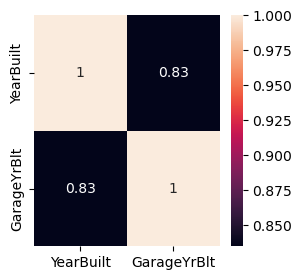

In [20]:
fig = plt.figure(figsize=(3,3))
sns.heatmap(num_column_df[['YearBuilt','GarageYrBlt']].corr(),annot=True)

In [21]:
num_column_df['GarageYrBlt'] = num_column_df['GarageYrBlt'].fillna(num_column_df['YearBuilt'])
num_column_df['LotFrontage'] = num_column_df['LotFrontage'].fillna(num_column_df['LotFrontage'].median())
num_column_df['MasVnrArea'] = num_column_df['MasVnrArea'].fillna(num_column_df['MasVnrArea'].median())
num_column_df = num_column_df.fillna(value=0)

In [22]:
#num_column_df.isna().sum()

In [23]:
object_column_df.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolArea', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'train'],
      dtype='object')

In [24]:
def nunique_percent(data,columns):
    for col in columns:
        df = data[col].value_counts()
        df = pd.DataFrame(df)
        df = df/len(data)
    return df
for i in object_column_df:
    print(nunique_percent(object_column_df,[i]))

     MSSubClass
20         0.37
60         0.20
50         0.10
120        0.06
30         0.05
70         0.04
160        0.04
80         0.04
90         0.04
190        0.02
85         0.02
75         0.01
45         0.01
180        0.01
40         0.00
150        0.00
         MSZoning
RL           0.78
RM           0.16
FV           0.05
RH           0.01
C (all)      0.01
      Street
Pave    1.00
Grvl    0.00
     LotShape
Reg      0.64
IR1      0.33
IR2      0.03
IR3      0.01
     LandContour
Lvl         0.90
HLS         0.04
Bnk         0.04
Low         0.02
        Utilities
AllPub       1.00
NoSeWa       0.00
         LotConfig
Inside        0.73
Corner        0.18
CulDSac       0.06
FR2           0.03
FR3           0.00
     LandSlope
Gtl       0.95
Mod       0.04
Sev       0.01
         Neighborhood
NAmes            0.15
CollgCr          0.09
OldTown          0.08
Edwards          0.07
Somerst          0.06
NridgHt          0.06
Gilbert          0.06
Sawyer           0.05


- 挑選出98%以上都為相同資料的欄位做刪除
- Street,Utilites,Condition2,RoofMatl,Heating

稍微視覺化分布看一下

<AxesSubplot:>

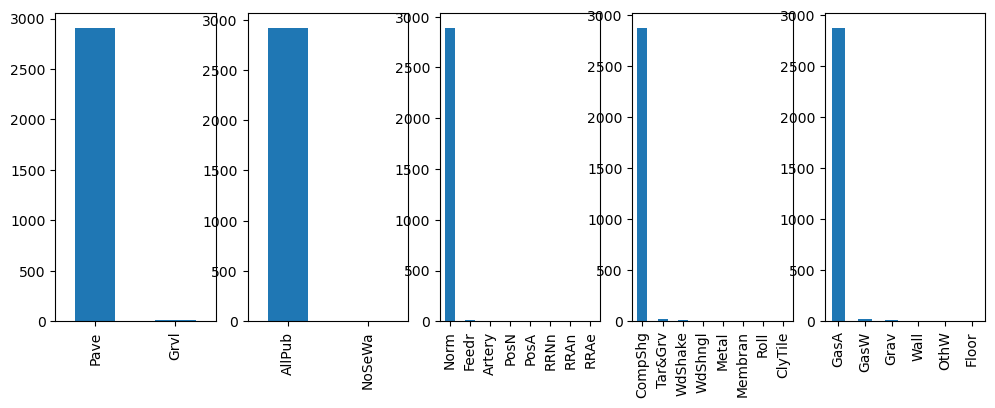

In [25]:
fig =plt.figure(figsize=(12,4))
plt.subplot(151)
object_column_df.Street.value_counts().plot.bar()
plt.subplot(152)
object_column_df.Utilities.value_counts().plot.bar()
plt.subplot(153)
object_column_df.Condition2.value_counts().plot.bar()
plt.subplot(154)
object_column_df.RoofMatl.value_counts().plot.bar()
plt.subplot(155)
object_column_df.Heating.value_counts().plot.bar()

In [26]:
object_column_df.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolArea', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'train'],
      dtype='object')

In [27]:
drop_col = ['Street','Utilities','Condition2','RoofMatl','Heating']
object_column_df.drop(drop_col,axis=1,inplace=True)

In [28]:
num_column_df['House_age'] = object_column_df['YrSold']-num_column_df['YearBuilt']
num_column_df['House_age'].describe()

count   2919.00
mean      36.48
std       30.34
min       -1.00
25%        7.00
50%       35.00
75%       54.50
max      136.00
Name: House_age, dtype: float64

In [29]:
num_column_df['House_age'] = object_column_df['YrSold']-num_column_df['YearBuilt']
num_column_df['House_age'].describe()

count   2919.00
mean      36.48
std       30.34
min       -1.00
25%        7.00
50%       35.00
75%       54.50
max      136.00
Name: House_age, dtype: float64

In [30]:
num_column_df.loc[object_column_df['YrSold'] < num_column_df['YearBuilt'],'YearBuilt' ]=2007
num_column_df['House_age'] = object_column_df['YrSold']-num_column_df['YearBuilt']
num_column_df['House_age'].describe()

count   2919.00
mean      36.48
std       30.34
min        0.00
25%        7.00
50%       35.00
75%       54.50
max      136.00
Name: House_age, dtype: float64

In [31]:
num_column_df.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'House_age'],
      dtype='object')

In [32]:
object_column_df.columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolArea', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'train'],
      dtype='object')

In [33]:
num_column_df['TotalBsmtBath'] = object_column_df['BsmtFullBath']+object_column_df['BsmtHalfBath']*0.5
num_column_df['TotalBath'] = object_column_df['FullBath']+object_column_df['HalfBath']*0.5
num_column_df['TotalSA'] = num_column_df['TotalBsmtSF']+num_column_df['1stFlrSF']+num_column_df['2ndFlrSF']

In [34]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
object_column_df['ExterQual']=object_column_df['ExterQual'].map(bin_map)
object_column_df['ExterCond']=object_column_df['ExterCond'].map(bin_map)
object_column_df['BsmtCond']=object_column_df['BsmtCond'].map(bin_map)
object_column_df['BsmtQual']=object_column_df['BsmtQual'].map(bin_map)
object_column_df['HeatingQC']=object_column_df['HeatingQC'].map(bin_map)
object_column_df['KitchenQual']=object_column_df['KitchenQual'].map(bin_map)
object_column_df['FireplaceQu']=object_column_df['FireplaceQu'].map(bin_map)
object_column_df['GarageQual']=object_column_df['GarageQual'].map(bin_map)
object_column_df['GarageCond']=object_column_df['GarageCond'].map(bin_map)
object_column_df['CentralAir'] = object_column_df['CentralAir'].map(bin_map)
object_column_df['LotShape'] = object_column_df['LotShape'].map(bin_map)
object_column_df['BsmtExposure'] = object_column_df['BsmtExposure'].map(bin_map)
object_column_df['BsmtFinType1'] = object_column_df['BsmtFinType1'].map(bin_map)
object_column_df['BsmtFinType2'] = object_column_df['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
object_column_df['PavedDrive'] = object_column_df['PavedDrive'].map(PavedDrive)

In [35]:
#挑object
rest_object_columns = object_column_df.select_dtypes(include=['object'])
#one hot encoding
object_column_df = pd.get_dummies(object_column_df, columns=rest_object_columns.columns) 

In [36]:
object_column_df.dtypes

MSSubClass               int64
LotShape                 int64
OverallQual              int64
OverallCond              int64
ExterQual                int64
                         ...  
SaleCondition_AdjLand    uint8
SaleCondition_Alloca     uint8
SaleCondition_Family     uint8
SaleCondition_Normal     uint8
SaleCondition_Partial    uint8
Length: 180, dtype: object

In [37]:
object_column_df['MSSubClass'] = LabelEncoder().fit_transform(object_column_df['MSSubClass'])

In [38]:
data_final = pd.concat([object_column_df, num_column_df], axis=1,sort=False)
data_final

,MSSubClass,LotShape,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,House_age,TotalBsmtBath,TotalBath,TotalSA
0,5,3,7,5,4,2,4,2,2,6,...,0,61,0,0,0,0,5,1.00,2.50,2566.00
1,0,3,6,8,2,2,4,2,4,5,...,298,0,0,0,0,0,31,0.50,2.00,2524.00
2,5,2,7,5,4,2,4,2,2,6,...,0,42,0,0,0,0,7,1.00,2.50,2706.00
3,6,2,7,5,2,2,2,4,2,5,...,0,35,272,0,0,0,91,1.00,1.00,2473.00
4,5,2,8,5,4,2,4,2,3,6,...,192,84,0,0,0,0,8,1.00,2.50,3343.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,13,3,4,7,2,2,2,2,2,1,...,0,0,0,0,0,0,36,0.00,1.50,1638.00
1455,13,3,4,5,2,2,2,2,2,3,...,0,24,0,0,0,0,36,0.00,1.50,1638.00
1456,0,3,5,7,2,2,2,2,2,5,...,474,0,0,0,0,0,46,1.00,1.00,2448.00
1457,9,3,5,5,2,2,4,2,3,6,...,80,32,0,0,0,700,14,0.50,1.00,1882.00


In [39]:
data_final

,MSSubClass,LotShape,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,House_age,TotalBsmtBath,TotalBath,TotalSA
0,5,3,7,5,4,2,4,2,2,6,...,0,61,0,0,0,0,5,1.00,2.50,2566.00
1,0,3,6,8,2,2,4,2,4,5,...,298,0,0,0,0,0,31,0.50,2.00,2524.00
2,5,2,7,5,4,2,4,2,2,6,...,0,42,0,0,0,0,7,1.00,2.50,2706.00
3,6,2,7,5,2,2,2,4,2,5,...,0,35,272,0,0,0,91,1.00,1.00,2473.00
4,5,2,8,5,4,2,4,2,3,6,...,192,84,0,0,0,0,8,1.00,2.50,3343.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,13,3,4,7,2,2,2,2,2,1,...,0,0,0,0,0,0,36,0.00,1.50,1638.00
1455,13,3,4,5,2,2,2,2,2,3,...,0,24,0,0,0,0,36,0.00,1.50,1638.00
1456,0,3,5,7,2,2,2,2,2,5,...,474,0,0,0,0,0,46,1.00,1.00,2448.00
1457,9,3,5,5,2,2,4,2,3,6,...,80,32,0,0,0,700,14,0.50,1.00,1882.00


In [40]:
data_train = data_final[data_final['train'] == 1]
data_train =data_train.drop(['train'],axis=1)
data_test =data_final[data_final['train'] == 0]
data_test =data_test.drop(['train'],axis=1)

In [41]:
data_test

,MSSubClass,LotShape,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,House_age,TotalBsmtBath,TotalBath,TotalSA
0,0,3,5,6,2,2,2,2,2,3,...,140,0,0,0,120,0,49,0.00,1.00,1778.00
1,0,2,6,6,2,2,2,2,2,5,...,393,36,0,0,0,12500,52,0.00,1.50,2658.00
2,5,2,5,5,2,2,4,2,2,6,...,212,34,0,0,0,0,13,0.00,2.50,2557.00
3,5,2,6,6,2,2,2,2,2,6,...,360,36,0,0,0,0,12,0.00,2.50,2530.00
4,11,2,8,5,4,2,4,2,2,5,...,0,82,0,0,144,0,18,0.00,2.00,2560.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,13,3,4,7,2,2,2,2,2,1,...,0,0,0,0,0,0,36,0.00,1.50,1638.00
1455,13,3,4,5,2,2,2,2,2,3,...,0,24,0,0,0,0,36,0.00,1.50,1638.00
1456,0,3,5,7,2,2,2,2,2,5,...,474,0,0,0,0,0,46,1.00,1.00,2448.00
1457,9,3,5,5,2,2,4,2,3,6,...,80,32,0,0,0,700,14,0.50,1.00,1882.00


## 模型

In [42]:
Target = train.SalePrice
x_train,x_test,y_train,y_test = train_test_split(data_train,Target,test_size=0.33,random_state=0)

In [43]:
x_train

,MSSubClass,LotShape,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,House_age,TotalBsmtBath,TotalBath,TotalSA
1127,0,0,7,5,4,2,4,2,3,6,...,144,36,0,0,0,0,3,1.00,2.00,3060.00
1424,0,3,5,5,2,2,2,2,2,5,...,316,28,0,0,0,0,49,1.00,1.00,2368.00
587,9,2,5,6,2,2,2,2,3,5,...,0,0,0,0,0,0,27,1.00,1.00,1700.00
1157,11,2,7,5,4,2,4,2,2,6,...,172,62,0,0,0,0,2,1.00,2.00,2628.00
938,5,3,7,5,4,2,4,4,2,6,...,0,90,0,0,0,0,0,0.00,2.50,3353.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,5,3,8,5,4,2,4,2,2,6,...,0,128,0,0,180,0,10,1.00,2.50,3617.00
835,0,3,4,7,2,2,4,2,2,4,...,290,0,0,0,0,0,60,0.00,2.00,2134.00
1216,10,3,6,5,2,2,0,0,0,0,...,0,0,0,0,0,0,32,0.00,2.00,1902.00
559,11,3,7,5,4,2,4,2,4,1,...,143,20,0,0,0,0,3,0.00,2.00,2931.00


In [44]:

xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )


In [45]:
#Fitting
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

[12:47:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [46]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)


In [47]:
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))

Root Mean Square Error test = 26577.663031077544
Root Mean Square Error test = 27181.98514861055


In [48]:
xgb.fit(data_train,Target)
predict2 = xgb.predict(data_test)

[12:47:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
submission=pd.DataFrame(
    {
     "Id" :  test['Id'],
     "SalePrice": predict2
    }
)
submission.to_csv('submission.csv',index=False)